In [46]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers


In [47]:
datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    brightness_range=[1.0,1.3],
    rotation_range=15,)


def get_generator(path,img_size,batch_size,shuffle):
    images = datagen.flow_from_directory(path,
                                      target_size=img_size,
                                      batch_size=batch_size,
                                      class_mode='sparse',
                                      shuffle = shuffle)
    return images

In [48]:
# 1. Initialise training variables
train_path = "/kaggle/input/chest-xray-pneumonia/chest_xray/train"
test_path = "/kaggle/input/chest-xray-pneumonia/chest_xray/test"
valid_path = "/kaggle/input/chest-xray-pneumonia/chest_xray/val"
img_size = (224, 224)
batch_size = 32
l2_reg = regularizers.l2(0.0001)  

In [49]:
#2. Load the datasets 
train_set = get_generator(train_path,img_size,batch_size,shuffle=True)
test_set = get_generator(test_path,img_size,batch_size,shuffle=False)
valid_set = get_generator(valid_path,img_size,batch_size,shuffle=True)

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


In [50]:
import matplotlib.pyplot as plt
import numpy as np

def plot_class_samples(generator, class_names, n_per_class=4):
    images, labels = next(generator)  # Get one batch of data
    labels = labels.astype(int)

    fig = plt.figure(figsize=(16, 4))

    count = {label: 0 for label in np.unique(labels)}

    i = 0
    plot_index = 1
    while i < len(images) and any(v < n_per_class for v in count.values()):
        label = labels[i]
        if count[label] < n_per_class:
            ax = fig.add_subplot(1, n_per_class * len(class_names), plot_index)
            plt.imshow(images[i])
            plt.title(class_names[label])
            plt.axis('off')
            count[label] += 1
            plot_index += 1
        i += 1

    plt.tight_layout()
    plt.show()

    

['NORMAL', 'PNEUMONIA']


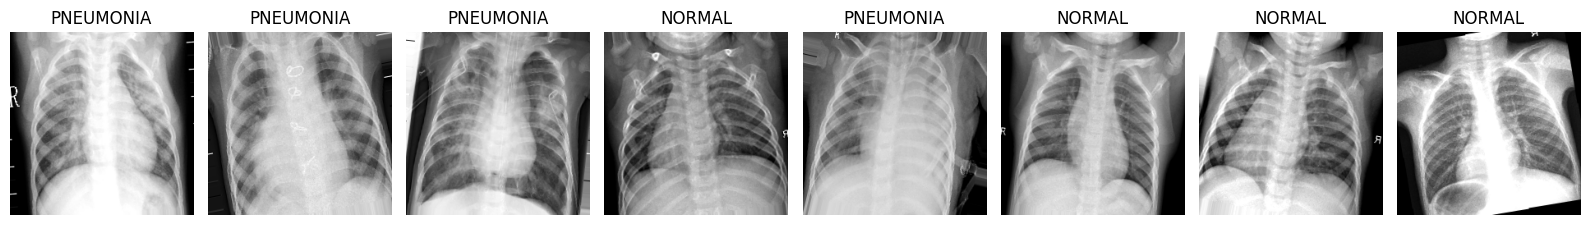

In [51]:
class_names = list(train_set.class_indices.keys())
print(class_names)

plot_class_samples(train_set, class_names, n_per_class=4)

In [52]:
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available: 2


In [53]:
def inception_block(input_layer, f1, f3r, f3, f5r, f5, proj):
    path1 = tf.keras.layers.Conv2D(f1, (1, 1), padding="same", activation="relu")(input_layer)

    path2 = tf.keras.layers.Conv2D(f3r, (1, 1), padding="same", activation="relu")(input_layer)
    path2 = tf.keras.layers.Conv2D(f3, (3, 3), padding="same", activation="relu", kernel_regularizer=l2_reg)(path2)

    path3 = tf.keras.layers.Conv2D(f5r, (1, 1), padding="same", activation="relu",)(input_layer)
    path3 = tf.keras.layers.Conv2D(f5, (5, 5), padding="same", activation="relu", kernel_regularizer=l2_reg)(path3)

    path4 = tf.keras.layers.MaxPooling2D((3, 3), strides=1, padding='same')(input_layer)
    path4 = tf.keras.layers.Conv2D(proj, (1, 1), padding="same", activation="relu", )(path4)

    output = tf.keras.layers.Concatenate(axis=-1)([path1, path2, path3, path4])
    return output

In [54]:
class LocalResponseNorm(tf.keras.layers.Layer):
    def call(self, inputs):
        return tf.nn.local_response_normalization(inputs)

In [55]:
input_layer = tf.keras.Input(shape=(224, 224, 3))

# Stem
x = tf.keras.layers.Conv2D(64, 7, strides=2, padding="valid", activation="relu")(input_layer)
x = tf.keras.layers.MaxPooling2D(pool_size=3, strides=2, padding='same')(x)
x = LocalResponseNorm()(x)

x = tf.keras.layers.Conv2D(64, 1, strides=1, activation="relu", padding='same', kernel_regularizer=l2_reg)(x)
x = tf.keras.layers.Conv2D(192, 3, strides=1, activation="relu", padding='same')(x)
x = LocalResponseNorm()(x)
x = tf.keras.layers.MaxPooling2D(pool_size=3, strides=2, padding='same')(x)

# Inception 3a → 3b
x = inception_block(x, f1=64, f3r=96, f3=128, f5r=16, f5=32, proj=32)
x = inception_block(x, f1=128, f3r=128, f3=192, f5r=32, f5=96, proj=64)
x = tf.keras.layers.MaxPooling2D(pool_size=3, strides=2, padding='same')(x)

# Inception 4a → 4e
x = inception_block(x, f1=192, f3r=96, f3=208, f5r=16, f5=48, proj=64)
x = inception_block(x, f1=160, f3r=112, f3=224, f5r=24, f5=64, proj=64)
x = inception_block(x, f1=128, f3r=128, f3=256, f5r=24, f5=64, proj=64)
x = inception_block(x, f1=112, f3r=144, f3=288, f5r=32, f5=64, proj=64)
x = inception_block(x, f1=256, f3r=160, f3=320, f5r=32, f5=128, proj=128)
x = tf.keras.layers.MaxPooling2D(pool_size=2, strides=2, padding='same')(x)

# Inception 5a → 5b
x = inception_block(x, f1=256, f3r=160, f3=320, f5r=32, f5=128, proj=128)
x = inception_block(x, f1=384, f3r=192, f3=384, f5r=48, f5=128, proj=128)

# Final layers
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.4)(x)
output_layer = tf.keras.layers.Dense(len(class_names), activation='softmax')(x)

model = tf.keras.Model(inputs=input_layer, outputs=output_layer)

In [56]:
optimizer = tf.keras.optimizers.Adam()

model.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=[
        'accuracy'
    ]
)

In [60]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

callbacks = [
    ModelCheckpoint("best_model.keras",  
                    save_best_only=True,
                    monitor='val_accuracy'),        
    EarlyStopping(patience=5, restore_best_weights=True)
]

In [ ]:
history = model.fit(
    train_set,
    validation_data=valid_set,
    epochs=100,
    callbacks=callbacks
)

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title("Training vs Validation Accuracy")
plt.show()


In [ ]:
model.evaluate(test_set)

20/20 ━━━━━━━━━━━━━━━━━━━━ 11s 526ms/step


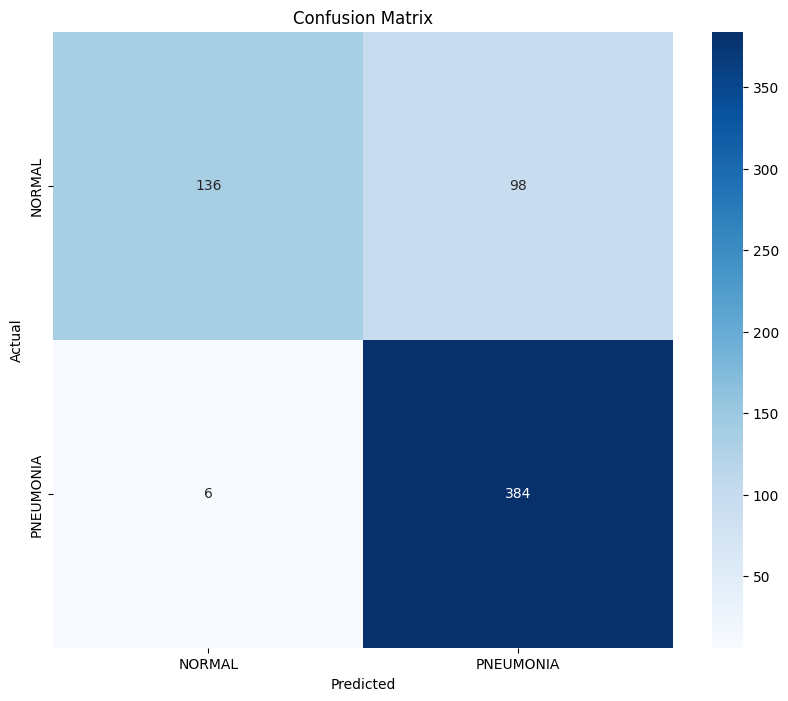

              precision    recall  f1-score   support

      NORMAL       0.96      0.58      0.72       234
   PNEUMONIA       0.80      0.98      0.88       390

    accuracy                           0.83       624
   macro avg       0.88      0.78      0.80       624
weighted avg       0.86      0.83      0.82       624



In [59]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# 🔹 Predict with the model
pred_probs = model.predict(test_set)
y_pred = np.argmax(pred_probs, axis=1)

# 🔹 Get true labels
y_true = test_set.classes  # Works for ImageDataGenerator or flow_from_directory

# 🔹 Confusion matrix
cm = confusion_matrix(y_true, y_pred)

# 🔹 Optional: Class names (from generator)
class_names = list(test_set.class_indices.keys())

# 🔹 Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# 🔹 Optional: Print classification report
print(classification_report(y_true, y_pred, target_names=class_names))


In [ ]:
model.save("/kaggle/working/best_model.keras")  # Full model (Keras 3+ recommended format)

In [57]:
# Custom layer
class LocalResponseNorm(tf.keras.layers.Layer):
    def call(self, inputs):
        return tf.nn.local_response_normalization(inputs)

# Load the saved model
model = tf.keras.models.load_model(
    '/kaggle/input/chest_xray_googlenet/tensorflow2/default/1/best_model.keras',
    custom_objects={"LocalResponseNorm": LocalResponseNorm}
)

model.compile(optimizer='adam',loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.fit(train_set, validation_data=valid_set, epochs=10, callbacks=callbacks)


Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 139s 632ms/step - accuracy: 0.9617 - loss: 0.1162 - val_accuracy: 0.7500 - val_loss: 0.4667
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 99s 604ms/step - accuracy: 0.9526 - loss: 0.1201 - val_accuracy: 0.7500 - val_loss: 0.4511
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 99s 605ms/step - accuracy: 0.9574 - loss: 0.1348 - val_accuracy: 0.8750 - val_loss: 0.5582
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 99s 606ms/step - accuracy: 0.9573 - loss: 0.1223 - val_accuracy: 0.6875 - val_loss: 1.1490
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 99s 606ms/step - accuracy: 0.9628 - loss: 0.1087 - val_accuracy: 0.8750 - val_loss: 0.5414
Epoch 6/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 99s 603ms/step - accuracy: 0.9538 - loss: 0.1209 - val_accuracy: 0.9375 - val_loss: 0.5838
Epoch 7/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 98s 602ms/step - accuracy: 0.9554 - loss: 0.1150 - val_accuracy: 0.8750 - val_loss: 0.4306
Epoch 8/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 100s 610ms/step - accuracy: 0.9618 - loss:

20/20 ━━━━━━━━━━━━━━━━━━━━ 12s 558ms/step


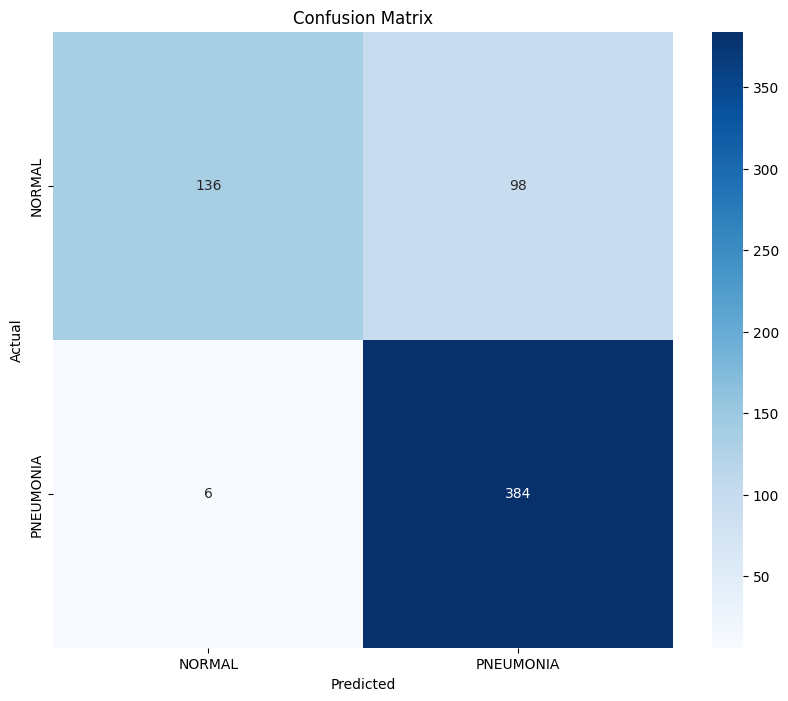

              precision    recall  f1-score   support

      NORMAL       0.96      0.58      0.72       234
   PNEUMONIA       0.80      0.98      0.88       390

    accuracy                           0.83       624
   macro avg       0.88      0.78      0.80       624
weighted avg       0.86      0.83      0.82       624



In [62]:
# 🔹 Predict with the model
pred_probs = model.predict(test_set)
y_pred = np.argmax(pred_probs, axis=1)

# 🔹 Get true labels
y_true = test_set.classes  # Works for ImageDataGenerator or flow_from_directory

# 🔹 Confusion matrix
cm = confusion_matrix(y_true, y_pred)

# 🔹 Optional: Class names (from generator)
class_names = list(test_set.class_indices.keys())

# 🔹 Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# 🔹 Optional: Print classification report
print(classification_report(y_true, y_pred, target_names=class_names))


In [61]:
model.save("/kaggle/working/best_model.keras")